
# Simplified Memory Requirements — Transformer Encoder (BERT-base Example)

*Generated on 2025-10-28 19:58:41*

This tutorial estimates **GPU memory** for a **Transformer encoder** during **training** and **inference** using simple **rules of thumb**.
We use **BERT-base** (≈110M parameters) as a concrete example. **No activation checkpointing**.



**Rules of thumb**
- Weights: ~2 bytes/param (FP16/BF16)
- Gradients: ~2 bytes/param
- AdamW optimizer: ~12 bytes/param
- Training activations: ~ `batch × seq × layers × hidden × 2 bytes × ~6`
- Inference activations: ~ `batch × seq × layers × hidden × 2 bytes × ~1.5`
- Encoders do **not** use a persistent KV cache at inference.


In [13]:

# ==============================
# Define variables (edit these)
# ==============================

# Model architecture (BERT-base-like)
num_params   = 110_000_000  # total parameters (~110M)
num_layers   = 12           # encoder layers
hidden_size  = 768          # hidden dimension
num_heads    = 12           # attention heads
head_dim     = hidden_size // num_heads  # per-head dimension (64)

# Data / batch
batch_size   = 1           # batch size (examples)
seq_len      = 512          # sequence length (tokens)

# Precision and constants
bytes_per_float          = 4    # FP16/BF16 precision (2 bytes)
adam_overhead_per_param  = 12   # AdamW optimizer overhead per parameter (bytes)
act_scale_train          = 6.0  # training activations multiplier
act_scale_infer          = 1.5  # inference activations multiplier

# Unit conversion
BYTES_PER_GIB = 1.073741824e9


In [14]:

# ==============================
# Helpers & Calculators
# ==============================

def training_memory_encoder(params, layers, hidden, batch, seq,
                            bytes_per_float=2, adam_overhead=12, act_scale=6.0):
    param_bytes = params * (bytes_per_float + bytes_per_float + adam_overhead)  # weights+grads+AdamW
    act_bytes   = batch * seq * layers * hidden * bytes_per_float * act_scale
    total_bytes = param_bytes + act_bytes
    return (total_bytes / BYTES_PER_GIB,
            param_bytes / BYTES_PER_GIB,
            act_bytes   / BYTES_PER_GIB)

def inference_memory_encoder(params, layers, hidden, batch, seq,
                             bytes_per_float=2, act_scale=1.5):
    weight_bytes = params * bytes_per_float
    act_bytes    = batch * seq * layers * hidden * bytes_per_float * act_scale
    total_bytes  = weight_bytes + act_bytes
    return (total_bytes / BYTES_PER_GIB,
            weight_bytes / BYTES_PER_GIB,
            act_bytes    / BYTES_PER_GIB)

def fmt_gib(x): return f"{x:.2f} GiB"


In [15]:

# ==============================
# Estimates for the current configuration
# ==============================

train_total, train_params, train_acts = training_memory_encoder(
    num_params, num_layers, hidden_size, batch_size, seq_len,
    bytes_per_float=bytes_per_float, adam_overhead=adam_overhead_per_param, act_scale=act_scale_train)

infer_total, infer_weights, infer_acts = inference_memory_encoder(
    num_params, num_layers, hidden_size, batch_size, seq_len,
    bytes_per_float=bytes_per_float, act_scale=act_scale_infer)

print("Training memory (encoder)")
print("  Total:               ", fmt_gib(train_total))
print("    Parameters+opt:    ", fmt_gib(train_params))
print("    Activations:       ", fmt_gib(train_acts))

print("Inference memory (encoder)")
print("  Total:               ", fmt_gib(infer_total))
print("    Weights:           ", fmt_gib(infer_weights))
print("    Activations:       ", fmt_gib(infer_acts))


Training memory (encoder)
  Total:                2.15 GiB
    Parameters+opt:     2.05 GiB
    Activations:        0.11 GiB
Inference memory (encoder)
  Total:                0.44 GiB
    Weights:            0.41 GiB
    Activations:        0.03 GiB


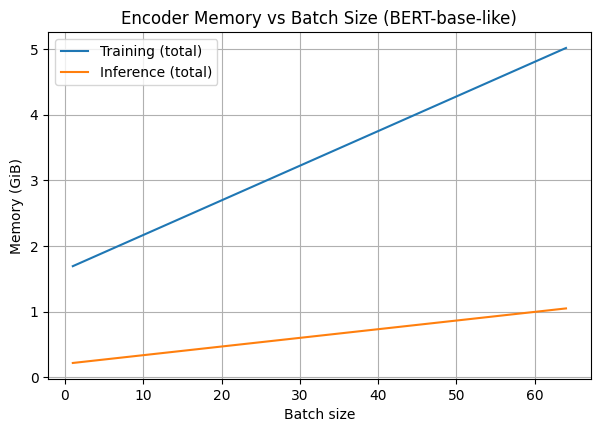

In [12]:

# ==============================
# Sensitivity: memory vs batch size (training & inference)
# ==============================
import numpy as np
import matplotlib.pyplot as plt

batch_values = np.array([1, 2, 4, 8, 16, 24, 32, 48, 64])
train_totals = []
infer_totals = []

for b in batch_values:
    tt, _, _ = training_memory_encoder(num_params, num_layers, hidden_size, b, seq_len,
                                       bytes_per_float=bytes_per_float, adam_overhead=adam_overhead_per_param, act_scale=act_scale_train)
    it, _, _ = inference_memory_encoder(num_params, num_layers, hidden_size, b, seq_len,
                                        bytes_per_float=bytes_per_float, act_scale=act_scale_infer)
    train_totals.append(tt); infer_totals.append(it)

plt.figure(figsize=(7,4.5))
plt.plot(batch_values, train_totals, label="Training (total)")
plt.plot(batch_values, infer_totals, label="Inference (total)")
plt.xlabel("Batch size")
plt.ylabel("Memory (GiB)")
plt.title("Encoder Memory vs Batch Size (BERT-base-like)")
plt.grid(True); plt.legend(); plt.show()



## Simple Rules of Thumb (Encoder)

- **Training memory ≈ 16 bytes/param + activations.**  
  Activations scale as `batch × seq × layers × hidden × 2 bytes × ~6` (no checkpointing).

- **Inference memory ≈ weights + working activations (no KV cache).**  
  A factor of **~1–2× hidden bytes** per token per layer typically covers inference workspace.

- **How to fit memory:**
  - Reduce `batch_size` or `seq_len` — activations scale linearly with both.
  - Quantize weights for inference (INT8 or 4‑bit) to shrink the resident model memory.
  - ZeRO-1/2/3 shard parameters/gradients/optimizer across devices (training); activations stay per‑rank.
  - Sequence/hidden parallelism can shard activations (framework dependent).
